In [ ]:
! pip install -r render.requirements.txt 

In [1]:
import pyrender
import trimesh
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 1 Setup

## 1.1 Get Dataset and File Paths

In [2]:
folder = "./datasets" 
dataset = "dataset_basket_0" #CHANGE ME
camera_name = "Basler-LR"    #CHANGE ME

#####  Python download script

```bash
./scripts/dataset/get_dataset.py

options:
  -h, --help            show this help message and exit
  --camera {ALL, FLIR_polar, Photoneo, Basler-HR, Basler-LR}
                        Supply a camera id or or 'ALL' to download all cameras for the specified dataset
  --id {ALL, dataset_basket_0, dataset_basket_1,..., dataset_texturedbg_3}
                        Supply a dataset id or 'ALL' to download all datasets for specified camera
  --folder FOLDER       Folder to download/extract the datasets to
  --extract             Flag to extract the downloaded dataset(s)
```

In [ ]:
! pip install -r ./scripts/dataset/get_dataset.requirements.txt
! python ./scripts/dataset/get_dataset.py --id {dataset} --camera {camera_name} --extract

#####  __Alternative__ bash download script (can only download & extract one dataset at a time)

In [ ]:
# ! ./scripts/dataset/get_dataset.sh {dataset} {camera_name} {folder}

#### Get file paths

In [3]:
SCENE_INDEX = 0 #CHANGE ME
CAMERA_INDEX = 0 #CHANGE ME

scenes = sorted([f.path for f in os.scandir(os.path.join(folder, dataset, "test")) if f.is_dir()], key=lambda x: int(os.path.basename(x)))
scene = scenes[SCENE_INDEX]

cameras = sorted([f.path for f in os.scandir(scene) if f.is_dir()], key=lambda x: int(os.path.basename(x)))
camera = cameras[CAMERA_INDEX]

## 1.2 Utils

In [4]:
# Used to convert from OpenCV (our cameras) to OpenGL (pyrrender)

def flip_rotation_axes(rotation_matrix, flip_x=False, flip_y=False, flip_z=False):
    """
    Flip the specified axes of a 3x3 rotation matrix.

    Args:
    rotation_matrix (np.array): The original 3x3 rotation matrix.
    flip_x (bool): Whether to flip the X-axis.
    flip_y (bool): Whether to flip the Y-axis.
    flip_z (bool): Whether to flip the Z-axis.

    Returns:
    np.array: The rotation matrix after flipping the specified axes.
    """
    flipped_matrix = rotation_matrix.copy()

    if flip_x:
        flipped_matrix[1:3, :] = -flipped_matrix[1:3, :]

    if flip_y:
        flipped_matrix[[0, 2], :] = -flipped_matrix[[0, 2], :]

    if flip_z:
        flipped_matrix[:, [0, 1]] = -flipped_matrix[:, [0, 1]]

    return flipped_matrix

def flip_translation_vector(translation_vector, flip_x=False, flip_y=False, flip_z=False):
    """
    Flip the specified axes of a translation vector.

    Args:
    translation_vector (np.array): The original translation vector.
    flip_x (bool): Whether to flip along the X-axis.
    flip_y (bool): Whether to flip along the Y-axis.
    flip_z (bool): Whether to flip along the Z-axis.

    Returns:
    np.array: The translation vector after flipping the specified axes.
    """
    flipped_vector = translation_vector.copy()

    if flip_x:
        flipped_vector[0] = -flipped_vector[0]

    if flip_y:
        flipped_vector[1] = -flipped_vector[1]

    if flip_z:
        flipped_vector[2] = -flipped_vector[2]

    return flipped_vector

# 2 Rendering

In [5]:
#create scene with transparent background
scene = pyrender.Scene(bg_color=[0, 0, 0, 0])

## 2.1 Load the objects and their poses

In [6]:
obj_pose_json = os.path.join(camera, "scene_gt.json")
with open(obj_pose_json) as f:
    obj_poses = json.load(f)['0']


for obj_pose in obj_poses:
    part = obj_pose['obj_name']
    r = np.array(obj_pose['cam_R_m2w']).reshape((3, 3))
    t = np.array(obj_pose['cam_t_m2w']) 
    T_m2c = np.eye(4)  
    T_m2c[:3, :3] = r
    T_m2c[:3, 3] = t

    # Load the obj mesh if exists
    cad_file = os.path.join(folder, "models", f"{part}.stl")
    if not os.path.exists(cad_file):
        print(f"Error: CAD file not found: {part}, {cad_file}")
        continue  # Skip to the next pose if the model file doesn't exist

    part_trimesh = trimesh.load(cad_file)
    mesh = pyrender.Mesh.from_trimesh(part_trimesh)

    scene.add(mesh, pose=T_m2c)

## 2.2 Create camera 

In [7]:
# load camera parameters (intrinsics) and create camera
camera_json = os.path.join(camera, "scene_camera.json")
with open(camera_json) as f:
    camera_params = json.load(f)['0']
intrinsics = camera_params['cam_K']
K = np.array(intrinsics).reshape((3, 3)) 
icamera = pyrender.IntrinsicsCamera(fx=K[0][0], fy=K[1][1], cx=K[0][2], cy=K[1][2], zfar=10000)

# Setting up camera pose (extrinsics), convert from OpenCV to OpenGL 
T_c2w = np.eye(4) 
T_c2w[:3, :3] = flip_rotation_axes(np.eye(3) , flip_z=True, flip_y=True) 

# Add camera to scene
scene.add(icamera, pose=T_c2w)

## 2.3 Render

#### Off-Screen Rendering
See docs at https://pyrender.readthedocs.io/en/latest/examples/offscreen.html

In [8]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'
r = pyrender.OffscreenRenderer(1936, 1216)
color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.RGBA)

## 2.4 Display

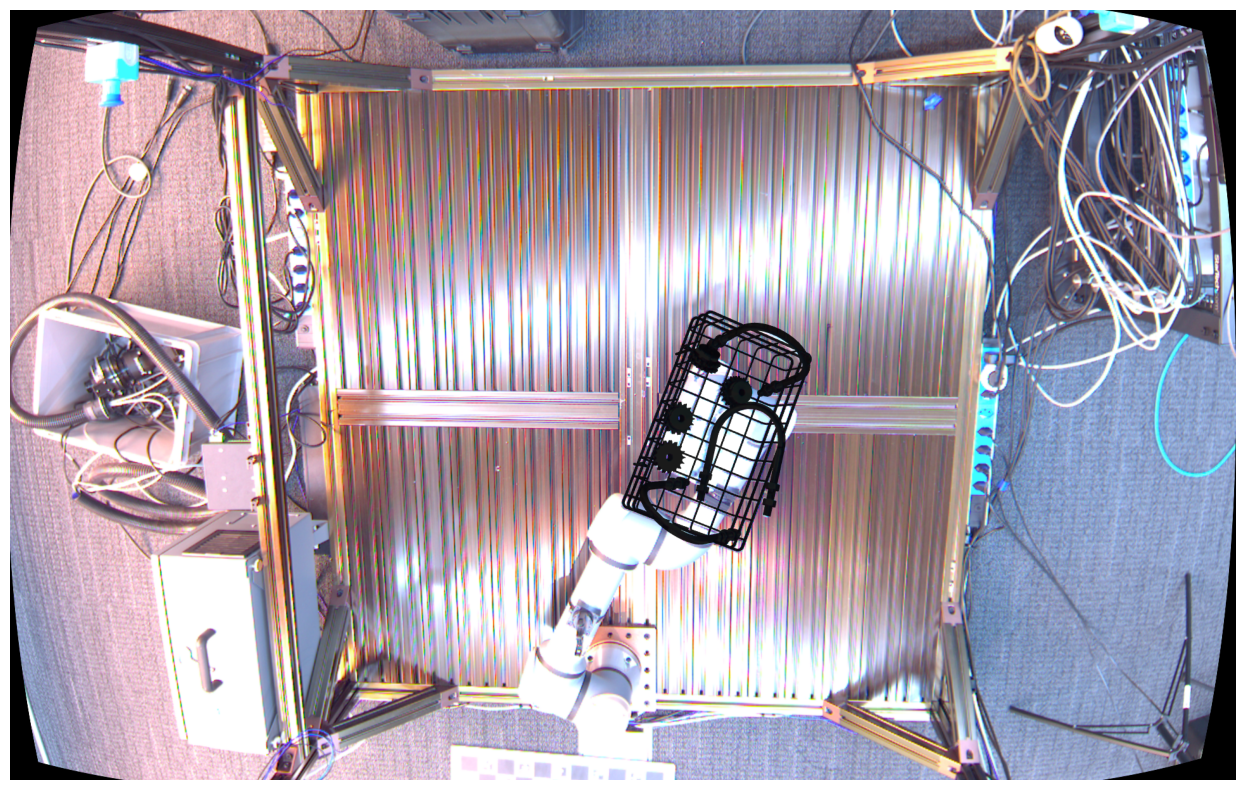

In [9]:
# Add image file
image_file = os.path.join(camera, "rgb", "0_200000.png")
im = cv2.imread(image_file)

fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(im)
plt.imshow(color, alpha=0.9)
plt.show()

# plt.savefig('image.png', bbox_inches='tight')
# print("Image saved to './image.png'")